In [28]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
filesurl = "/Users/mahmoudfathy/Developer/resources/datasets/free-spoken-digit-dataset/recordings/"
filename = "{}{}".format( filesurl, "9_yweweler_4.wav")

## Plot wav audio - time and amplitude 

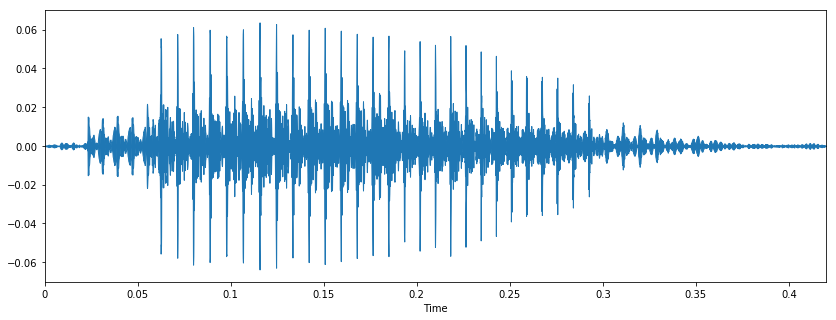

In [8]:
x, sr = librosa.load(filename)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

## Plot spectrogram audio - time, frequency and amplitude 

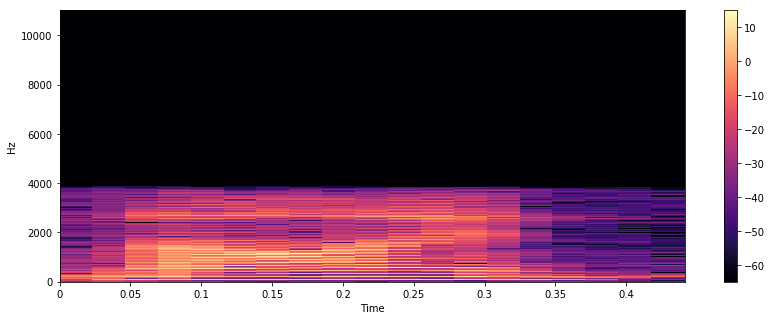

In [9]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### Plot spectrogram audio - Y frequency axis as log scale

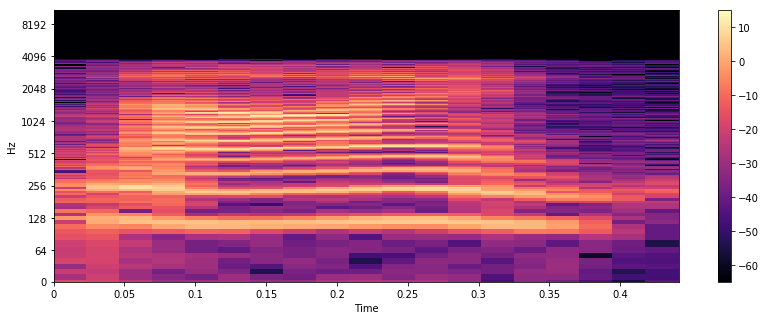

In [10]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [11]:
Xdb.shape

(1025, 19)

## Create tensor of audio recordings

### for all users saying "seven" 50 samples each

In [23]:
users = ["jackson", "nicolas", "theo", "yweweler"]
# dictionary of {name : [files of that name]}
filenames = dict(list(map(lambda name:\
         list((name, list(map(lambda x: "7_{}_{}.wav".format(name, x), \
             range(50))))), users)))

In [37]:
def file_to_specgram(filename):
    x, sr = librosa.load(filesurl + filename)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb, sr
jackson_specgrams = list((map(lambda filename:\
                        file_to_specgram(filename)[0], \
                        filenames["jackson"])))


(1025, 19)

In [43]:
# finding the max width of the spectrograms
mxT = max(map(lambda x: x.shape[1], jackson_specgrams))

In [52]:
# compute jacjson_specgrams but this time with padding 

def file_to_fixed_size_specgram(filename):
    Xdb, _ = file_to_specgram(filename)
    Xdb = np.pad(Xdb, ((0, 0), (0, mxT-Xdb.shape[1])), "constant")
    return Xdb

jackson_specgrams = np.array(list((map(file_to_fixed_size_specgram, \
                        filenames["jackson"]))))